### This NoteBook illustrates Inference/Scoring process


In [8]:
import os
import math
import pickle
import sys
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import plot_importance
import pickle
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,cross_validate,GridSearchCV,RandomizedSearchCV
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler,PowerTransformer
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from vincenty import vincenty
from datetime import datetime
import reverse_geocoder as rg
from shapely.geometry import mapping, shape
from shapely.prepared import prep
from shapely.geometry import Point
import requests
from fastai.tabular.core import add_datepart

### Inference/Scoring pipeline

- During inference will use stored object(models, transformers etc.) as we should not fit this again and hence use this information from training phase
- This pipeline would be shorter

Loading data frame and having a look at the data 

In [9]:
test_df = pd.read_csv('../data/test_data_hold.csv', parse_dates=['shipping_date'])
test_df.head()

# real_test = pd.read_csv('../data/test_data.csv', sep = ';', parse_dates=['shipping_date'])

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,is_adr,shipping_date,cost
0,23.61,109.10,27.46,106.75,0.469,0.000,True,2017-03-15,0.532
1,25.47,109.67,25.66,108.34,0.504,0.195,True,2017-09-28,0.207
2,23.27,106.88,26.98,110.81,0.311,0.195,True,2018-11-26,0.447
3,25.06,110.94,23.41,105.41,0.202,0.195,True,2017-07-03,0.442
4,24.72,106.25,27.23,111.25,0.504,0.195,True,2018-11-22,0.415


In [11]:
target = 'cost'
lat_1,lon_1,lat_2,lon_2 = 'origin_latitude','origin_longitude','destination_latitude','destination_longitude'
test_X = test_df.drop([target],axis=1)
Y = test_df[target]

### We need to apply sidentical treatment,feature engg. and transformation except for fitting


In [12]:
class FeatenggTransformer(BaseEstimator, RegressorMixin, TransformerMixin):

    def transform(self, X):
        
        """This pipeline transforms the dataframe to the desired
         features and shape"""

        X = self.add_date_feature(X)
        X = self.add_travel_features(X)
        X = self.get_country_feats(X)
        X = self.drop_unrequired_fields(X)
        return X

    def add_travel_features(self, X):

        """This Method creates distance features"""
        
        if not -90 <= X[lon_1].all() <= 90 or not -180 <= X[lat_1].all() <= 180 or not -90 <= X[lon_2].all() <= 90 or not -180 <= X[lat_2].all() <= 180:
            raise ValueError("Invalid latitude, longitude combination.")

        X['abs_diff_longitude'] = (X[lon_2] - X[lon_1]).abs()
        X['abs_diff_latitude'] = (X[lat_2] - X[lat_1]).abs()
        X['Vincenty_distance'] = X.apply(lambda x: vincenty((x[lat_1], \
            x[lon_1]), (x[lat_2], x[lon_2])\
                ,miles=True), axis = 1)

        # bearing (in degrees converted to radians)
        def bearing_array(lat1, lng1, lat2, lng2):
            AVG_EARTH_RADIUS = 6371  # in km
            lng_delta_rad = np.radians(lng2 - lng1)
            lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
            y = np.sin(lng_delta_rad) * np.cos(lat2)
            x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
            return np.degrees(np.arctan2(y, x))

        X['Bearing'] = bearing_array(X[lat_1], \
                    X[lon_1], X[lat_2], X[lon_2])
        X.loc[:, 'center_latitude'] = (X[lat_1].values + X[lat_2].values) / 2
        X.loc[:, 'center_longitude'] = (X[lon_1].values + X[lon_2].values) / 2
        return X

    def add_date_feature(self, X):
        
        """This Method creates time series/date features"""
        
        ref_date = '2017-01-01'
        if not (X['shipping_date'] >= ref_date).all():
            raise ValueError("Invalid Date Date should be later than {ref_date}")

        X['weekday'] = X['shipping_date'].dt.day_of_week
        X["is_weekend"] = np.where(X["weekday"] < 5, 0, 1)
        X['week_in_month'] = pd.to_numeric(X['shipping_date'].dt.day/7).\
        apply(lambda x: math.ceil(x))
        X['month'] = X['shipping_date'].dt.month
        X['day_count'] = (X['shipping_date'] - datetime.strptime(ref_date, "%Y-%m-%d"))/np.timedelta64(1, 'D')
        return X

    def get_country_feats(self, X):
        data = requests.get("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson").json()
        countries = {}
        for feature in data["features"]:
            geom = feature["geometry"]
            country = feature["properties"]["ADMIN"]
            countries[country] = prep(shape(geom))
        def get_country(row):
            point = Point(row[0], row[1])
            for country, geom in countries.items():
                if geom.contains(point):
                    return country
            return "unknown"
        X['destn_country']= X[[lon_2,lat_2]].apply(get_country,axis=1)
        X['origin_country'] = X[[lon_1,lat_1]].apply(get_country,axis=1)
        X['diff_country'] = np.where(X['origin_country'] == X['destn_country'],0,1) 
        return X   

    def drop_unrequired_fields(self, X):

        """Method for dropping unrequired fields"""

        return X.drop(['shipping_date','is_adr',lat_1,lon_1,lat_2,lon_2], axis=1)


In [13]:
fet =  FeatenggTransformer()
X = fet.transform(test_X)

- Please make sure all necessary objects(models, transformers etc.) are stored at the designated path

In [14]:
cat_cols = ['week_in_month', 'weekday', 'is_weekend', 'month','destn_country','origin_country']
num_cols = [col for col in list(X.columns) if col not in cat_cols]

class FeatureTransformer(BaseEstimator, RegressorMixin, TransformerMixin):

    """This Class is for FeatureTransform
        a) categorical feature encoding
        b) feature scaling
    """
    
    def __init__(self,cat_cols,num_cols,path):
        self.cat_cols,self.num_cols,self.path = cat_cols,num_cols,path
        if not os.path.exists(self.path):
            os.mkdir(self.path)

    def transform(self, X):

        """This pipeline transforms the categorical features to One-Hot Encoded and scales the 
         features"""

        X = self.encode_categorical(X)
        return X

    def encode_categorical(self, X):

        """This Method creates absolute difference features
        and deserializes(unpickle) the necessary objects for inference"""

        with open(os.path.join(self.path,'ohe.pkl') ,'rb') as fout:
            ohe = pickle.load(fout)
        x_cat_df = pd.DataFrame(ohe.transform(X[self.cat_cols]))
        x_cat_df.columns = ohe.get_feature_names_out(self.cat_cols)
        X = pd.concat([X[num_cols],x_cat_df],axis=1)
        return X

In [15]:
ft = FeatureTransformer(cat_cols=cat_cols,num_cols=num_cols,path='../artifacts_final/')
X_transformed = ft.transform(X)
X_transformed.head()

,weight,loading_meters,day_count,abs_diff_longitude,abs_diff_latitude,Vincenty_distance,Bearing,center_latitude,center_longitude,diff_country,...,month_7,month_8,month_9,month_10,month_11,month_12,destn_country_China,destn_country_Vietnam,origin_country_China,origin_country_Vietnam
0,0.469,0.000,73.0,2.35,3.85,302.920779,-28.345677,25.535,107.925,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.504,0.195,270.0,1.33,0.19,84.065196,-80.714713,25.565,109.005,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.311,0.195,694.0,3.93,3.71,354.713715,42.984374,25.125,108.845,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.202,0.195,183.0,5.53,1.65,366.970263,-106.969033,24.235,108.175,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.504,0.195,690.0,5.00,2.51,355.825243,59.742346,25.975,108.750,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


### Finally the Model prediction pipeline

- Please make sure all necessary objects(models, transformers etc.) are stored at the designated path

In [18]:
class Prediction(BaseEstimator,TransformerMixin):

    """Object to make prediction/inference using Model
    """

    def __init__(self, model_path = None, data_path = None):
        self.model_path  = model_path
        self.data_path = data_path

    def prediction(self,X):

        """Method to make prediction loading model and saves data"""

        with open(self.model_path, 'rb') as fout:
            self.model = pickle.load(fout)
        pred = self.model.predict(X)
        pred = pd.DataFrame({'cost':list(pred)})
        # pred.to_csv(self.data_path, index=False)
        return pred

In [19]:
model_path = os.path.join('../artifacts/','lgb_model.pkl')
data_path = os.path.join('../artifacts/','cost_prediction.csv')
p = Prediction(model_path,data_path)
pred = p.prediction(X_transformed)
print(r2_score(Y, pred))
mean_absolute_percentage_error(Y, pred)


0.8365787134596102


0.09983294349306979

In [169]:
model_path = os.path.join('../artifacts_final/','xgb_model.pkl')
p = Prediction(model_path,data_path)
pred1 = p.prediction(X_transformed.drop('year',axis=1))
print(r2_score(Y, pred1))
mean_absolute_percentage_error(Y, pred1)
# 0.8390565060833868
# 0.0996345033167226

0.839258321843332


0.09878935246576806

predicted mean:cost    0.343478
dtype: float64
actual mean:0.3437584408345175


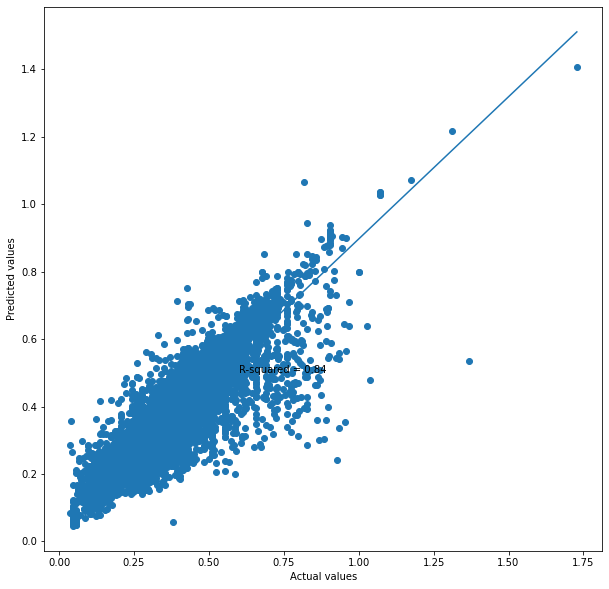

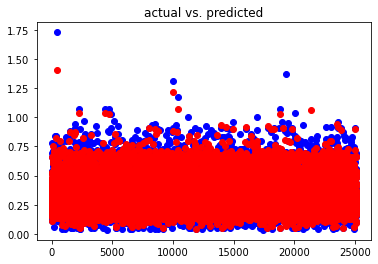

max actual 1.728
max prediction cost    1.405244
dtype: float64


In [29]:
#sklearnstackedregression model to be scored

# model_path = os.path.join('../artifacts_final/','stacked_model_final.pkl')
# p = Prediction(model_path,data_path)
# pred2 = p.prediction(X_transformed)
# print(r2_score(Y, pred2))
# mean_absolute_percentage_error(Y, pred2)
from matplotlib import pyplot as plt
print(f'predicted mean:{pred2.mean()}')
print(f'actual mean:{Y.mean()}')
r_squared = r2_score(Y,pred)
# print(r_squared)
plt.figure(figsize=(10,10))
plt.scatter(Y,pred2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(Y), np.poly1d(np.polyfit(Y, np.array(pred2).reshape(-1), 1))(np.unique(Y)))

plt.text(0.6, 0.5, 'R-squared = %0.2f' % r_squared)
plt.show()
def plotGraph(y_test,y_pred,regressorName):
    if max(Y) >= max(pred2.values):
        my_range = int(max(y_test))
    else:
        my_range = int(max(pred2))
    plt.scatter(range(len(Y)), Y, color='blue')
    plt.scatter(range(len(Y)), pred2, color='red')
    plt.title(regressorName)
    plt.show()
    return


# y_test = range(10)
# y_pred = np.random.randint(0, 10, 10)

plotGraph(Y, pred2, "actual vs. predicted")
print(f'max actual {Y.max()}')
print(f'max prediction {pred2.max()}')

# 0.8425403257261154
# 0.09689199813549092

In [89]:
# model_path = os.path.join('../artifacts/','rf_model.pkl')
# p = Prediction(model_path,data_path)
# pred3 = p.prediction(X_transformed)
# print(r2_score(Y, pred3))
# mean_absolute_percentage_error(Y, pred3)

0.8379781868181323


0.10212929958204307

In [43]:
0.8425403257261154  #sklearnstackedregression model(3 models with full data train)
0.09689199813549092

0.8413238858959429  #sklearnstackedregression model
0.09787482596440249

0.8408703268652307 #2/3 of xgb,1/3 of lgb
0.09871235189081189


from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
s = sp_uniform(loc=0.4, scale=0.8)
s.cdf()

TypeError: cdf() missing 1 required positional argument: 'x'

##                                                           Q&A